# 经典卷积神经网络 LeNet 

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
import d2l.torch as d2l

## 定义神经网络

In [2]:
class ReShapeLayer(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, x):
        return x.reshape(-1, 1, 28, 28)

In [5]:
net = nn.Sequential(
    ReShapeLayer(),
    
    nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.Sigmoid(), nn.AvgPool2d(kernel_size=2, stride=2),

    nn.Conv2d(6, 16, kernel_size=5), nn.Sigmoid(), nn.AvgPool2d(kernel_size=2, stride=2),

    nn.Flatten(),
    nn.Linear(16 * 5 * 5, 120), nn.Sigmoid(),
    nn.Linear(120, 84), nn.Sigmoid(),
    nn.Linear(84, 10), # nn.Softmax()    
)

In [8]:
X = torch.rand(size=(4, 28, 28), dtype=torch.float32)
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__, 'output shape: ', X.shape)

ReShapeLayer output shape:  torch.Size([4, 1, 28, 28])
Conv2d output shape:  torch.Size([4, 6, 28, 28])
Sigmoid output shape:  torch.Size([4, 6, 28, 28])
AvgPool2d output shape:  torch.Size([4, 6, 14, 14])
Conv2d output shape:  torch.Size([4, 16, 10, 10])
Sigmoid output shape:  torch.Size([4, 16, 10, 10])
AvgPool2d output shape:  torch.Size([4, 16, 5, 5])
Flatten output shape:  torch.Size([4, 400])
Linear output shape:  torch.Size([4, 120])
Sigmoid output shape:  torch.Size([4, 120])
Linear output shape:  torch.Size([4, 84])
Sigmoid output shape:  torch.Size([4, 84])
Linear output shape:  torch.Size([4, 10])


## Fashion-MNIST

In [11]:
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size=batch_size)

Using downloaded and verified file: ../data/FashionMNIST/raw/train-images-idx3-ubyte.gz
Extracting ../data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../data/FashionMNIST/raw

Using downloaded and verified file: ../data/FashionMNIST/raw/train-labels-idx1-ubyte.gz
Extracting ../data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



100.0%


Extracting ../data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



100.0%


Extracting ../data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



In [28]:
train_iter.dataset.targets

tensor([9, 0, 0,  ..., 3, 0, 5])

In [20]:
X, y = train_iter.dataset[0]

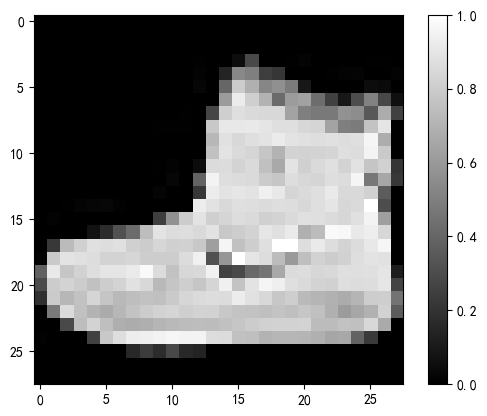

In [27]:
plt.imshow(X[0], cmap='gray')  # 使用灰度色彩映射
plt.colorbar()  # 添加颜色条
plt.show()

## 训练神经网络

In [36]:
def evaluate_accuracy_gpu(net, data_iter, device=None): #@save
    """使用GPU计算模型在数据集上的精度"""
    if isinstance(net, nn.Module):
        net.eval()  # 设置为评估模式
        if not device:
            device = next(iter(net.parameters())).device
    # 正确预测的数量，总预测的数量
    metric = d2l.Accumulator(2)#创建一个累加器，包含2个要累加的元素
    with torch.no_grad():
        for X, y in data_iter:
            if isinstance(X, list):
                # BERT微调所需的（之后将介绍）
                X = [x.to(device) for x in X]
            else:
                X = X.to(device)
            y = y.to(device)
            metric.add(d2l.accuracy(net(X), y), y.numel())#把每一组数据预测结果正确的个数和长度累加
    return metric[0] / metric[1]

In [37]:
#@save
def train_ch6(net, train_iter, test_iter, num_epochs, lr, device):
    """用GPU训练模型(在第六章定义)"""
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)#对linear类型的层用xavier初始化
    net.apply(init_weights)
    print('training on', device)
    net.to(device)
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])#动画需要
    timer, num_batches = d2l.Timer(), len(train_iter)
    for epoch in range(num_epochs):
        # 训练损失之和，训练准确率之和，范例数
        metric = d2l.Accumulator(3)
        net.train()
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()#梯度清零
            X, y = X.to(device), y.to(device)
            y_hat = net(X)#正向传播
            l = loss(y_hat, y)#计算损失
            l.backward()#反向传播
            optimizer.step()#梯度下降
            with torch.no_grad():
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])#训练损失之和，训练准确率之和，范例数
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (train_l, train_acc, None))
        test_acc = evaluate_accuracy_gpu(net, test_iter)#评估测试集的精度
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')

In [45]:
batch_size, lr , num_epochs = 256, 0.1, 50
loss = nn.CrossEntropyLoss()
trainer = torch.optim.SGD(net.parameters(), lr=lr)

In [43]:
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size=batch_size)

loss 0.499, train acc 0.816, test acc 0.808
20264.3 examples/sec on cpu


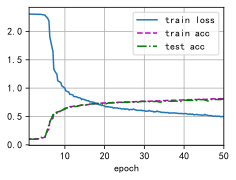

In [44]:
train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

## 练习题

1. 将平均汇聚层替换为最大汇聚层，会发生什么？

loss 0.423, train acc 0.847, test acc 0.809
19804.0 examples/sec on cpu


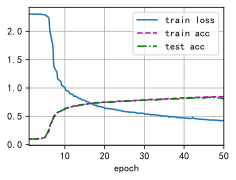

In [46]:
net = nn.Sequential(
    ReShapeLayer(),
    
    nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.Sigmoid(), nn.MaxPool2d(kernel_size=2, stride=2),

    nn.Conv2d(6, 16, kernel_size=5), nn.Sigmoid(), nn.MaxPool2d(kernel_size=2, stride=2),

    nn.Flatten(),
    nn.Linear(16 * 5 * 5, 120), nn.Sigmoid(),
    nn.Linear(120, 84), nn.Sigmoid(),
    nn.Linear(84, 10), # nn.Softmax()    
)
train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

2. 尝试构建一个基于LeNet的更复杂的网络，以提高其准确性。
    1. 调整卷积窗口大小。
    1. 调整输出通道的数量。
    1. 调整激活函数（如ReLU）。
    1. 调整卷积层的数量。
    1. 调整全连接层的数量。
    1. 调整学习率和其他训练细节（例如，初始化和轮数）

loss 0.185, train acc 0.930, test acc 0.885
20445.0 examples/sec on cpu


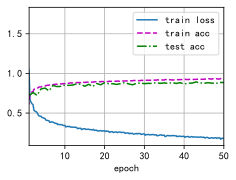

In [47]:
net = nn.Sequential(
    ReShapeLayer(),
    
    nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.ReLU(), nn.AvgPool2d(kernel_size=2, stride=2),

    nn.Conv2d(6, 16, kernel_size=5), nn.ReLU(), nn.AvgPool2d(kernel_size=2, stride=2),

    nn.Flatten(),
    nn.Linear(16 * 5 * 5, 120), nn.ReLU(),
    nn.Linear(120, 84), nn.ReLU(),
    nn.Linear(84, 10), # nn.Softmax()    
)
train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

loss 1.653, train acc 0.808, test acc 0.790
19820.0 examples/sec on cpu


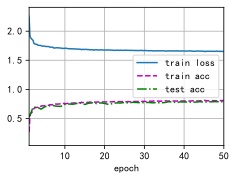

In [48]:
net = nn.Sequential(
    ReShapeLayer(),
    
    nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.ReLU(), nn.AvgPool2d(kernel_size=2, stride=2),

    nn.Conv2d(6, 16, kernel_size=5), nn.ReLU(), nn.AvgPool2d(kernel_size=2, stride=2),

    nn.Flatten(),
    nn.Linear(16 * 5 * 5, 120), nn.ReLU(),
    nn.Linear(120, 84), nn.ReLU(),
    nn.Linear(84, 10), nn.Softmax()    
)
train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

loss 0.156, train acc 0.940, test acc 0.889
11217.5 examples/sec on cpu


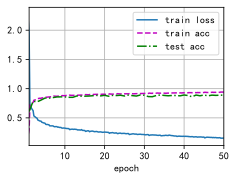

In [52]:
net = nn.Sequential(
    ReShapeLayer(),
    
    nn.Conv2d(1, 6, kernel_size=3, padding=1), nn.ReLU(),
    nn.Conv2d(6, 6, kernel_size=3, padding=1), nn.ReLU(),
    nn.Conv2d(6, 6, kernel_size=3, padding=1), nn.ReLU(), nn.AvgPool2d(kernel_size=2, stride=2),

    nn.Conv2d(6, 16, kernel_size=5), nn.ReLU(), nn.AvgPool2d(kernel_size=2, stride=2),

    nn.Flatten(),
    nn.Linear(16 * 5 * 5, 120), nn.ReLU(),
    nn.Linear(120, 84), nn.ReLU(),
    nn.Linear(84, 10)
)
train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

3. 在MNIST数据集上尝试以上改进的网络。

4. 显示不同输入（例如毛衣和外套）时，LeNet第一层和第二层的激活值。

loss 0.187, train acc 0.928, test acc 0.889
23100.1 examples/sec on cpu


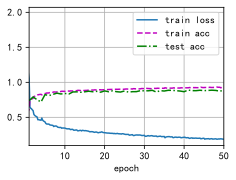

In [53]:
net = nn.Sequential(
    ReShapeLayer(),
    
    nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.ReLU(), nn.AvgPool2d(kernel_size=2, stride=2),

    nn.Conv2d(6, 16, kernel_size=5), nn.ReLU(), nn.AvgPool2d(kernel_size=2, stride=2),

    nn.Flatten(),
    nn.Linear(16 * 5 * 5, 120), nn.ReLU(),
    nn.Linear(120, 84), nn.ReLU(),
    nn.Linear(84, 10), # nn.Softmax()    
)
train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())